<a href="https://colab.research.google.com/github/chrysshawk/Geolocation_Business_Opportunities/blob/master/Geolocation_Business_Opportunities_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook: Identifying Restaurant Business Opportunities
  

*by Christoffer Haukvik, 2020*


##Table of Contents

1. Introduction
2. Data: Collection and pre-processing
3. Data Analysis for Methodology
4. Conclusion

##1. Introduction <a name="introduction"></a>

This notebook is used to collect the data required for the task of identifying business opportunities, and is the basis for the results as provided in the final report.

##2. Data: Collection and pre-processing <a name="data"></a>
In this section, we will import the required libraries, define the project's input parameters, collect the required data, and perform any data pre-processing.

###Data collection: Code

####Defining Project Input Parameters

We first need to define the project's input parameters for the city we are goint to analyze; we do this below.

In [ ]:
# Defining input city
CITY = 'Las Vegas'
STATE = 'Nevada'
COUNTRY = 'United States'
radius = 15 # radius (km) from location center to include in scope

INPUT_ADDRESS = ', '.join((CITY,STATE,COUNTRY))
print('This project will investigate and analyse', INPUT_ADDRESS,
      'and the surrounding area with a radius of', radius, 'km.')

This project will investigate and analyse Las Vegas, Nevada, United States and the surrounding area with a radius of 15 km.


#### Defining credentials for APIs, radius of project scope, and selected venue category

Next, we must define the credentials to use with the Geonames and FourSquare APIs. 

Additionally, this is where we define the radius we will include in the scope, as well as which type of venue we are going to investigate.


In [ ]:
# Required input parameters:
gnames_user = 'xxx' # yor user name for geonames service

# Foursquare Parameters
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # limit on how many entries Foursquare will return
RADIUS = radius*1000 # radius in meters
POPULARITY = 1 # venues will be sorted according to popularity

# Defining FourSquare venue category
SECTIONS = ['food', 'drinks', 'coffee', 'shops', 'arts', 'outdoors', 'sights'] # possible sections/categories
SECTION = SECTIONS[0] # Selecting the Food section, which FourSquare treats as restaurants

####Importing required libraries
Below we import the required libraries for use in the project.

In [ ]:
# Defining imports
# importing necessary libraries
import pandas as pd # library for analysis
import numpy as np # library to handle data

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy
# install the Geocoder
!pip -q install geocoder
import geocoder
import folium # map rendering library

import requests # library to handle requests
import urllib.request # import the library we use to open URLs
from pandas.io.json import json_normalize # library to flatten json objects

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# Math library for mathematical calculations
import math

# import k-means from clustering stage
from sklearn.cluster import KMeans

import warnings #used to suppress warnings

print('Libraries imported.')

     |████████████████████████████████| 102kB 5.2MB/s 
Libraries imported.


Next we also define the defaults to use with this notebook.

In [ ]:
# Defining defaults
sns.set_style('white')
warnings.filterwarnings('ignore') # Suppressing warnings
pd.set_option('display.max_columns', None)

#### Retrieving location coordinates
The first step of the analysis is to retrieve the geographical coordinates of the selected location. In order to do so, we will use Geocoder (https://geocoder.readthedocs.iofour).

In [ ]:
# Using Geocoder Arcgis source to look up city
g = geocoder.arcgis(INPUT_ADDRESS)

# Assigning coordinates
latitude, longitude = g.latlng
print('The geograpical coordinates of', CITY, 'are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Las Vegas are 36.17193000000003, -115.14000999999996.


#### Retrieving Zip/Postal code details of given area
Next, we will use the GeoNames API to retrieve information of the area surrounding our location, such as the zip/postal codes, the latitudes and longitudes, as well as the surrounding location names.

In [ ]:
# Look up postal codes within given radius of city center
maxRows = 500 # retrieve the maximum amount of postal codes

# Define the url request
url = 'http://api.geonames.org/findNearbyPostalCodesJSON?lat={}&lng={}&radius={}&maxRows={}&username={}'.format(
    latitude,
    longitude,
    radius,
    maxRows,
    gnames_user
)
postal_codes = requests.get(url).json() # Make the request
print('There are', len(postal_codes['postalCodes']), 'postal codes in', CITY)

There are 71 postal codes in Las Vegas


Now, we will extract the necessary information from the received result.

In [ ]:
# Extracting the json results to list
location_list = []
location_list.append([(
    pc['postalCode'],
    pc['placeName'],
    pc['adminName1'],
    pc['adminCode1'],
    pc['countryCode'],
    pc['lat'],
    pc['lng']) for pc in postal_codes['postalCodes']])

# Creating a dataframe from the list
location_df = pd.DataFrame([entry for location_list in location_list for entry in location_list])
location_df.columns = ['Postal_Code', 'Place_Name', 'State_Name', 'State_Code', 'Country_Code', 'PC_Latitude', 'PC_Longitude']
location_df.sort_values(by='Postal_Code', inplace=True)
print('The structure of the data we have of the surrounding area looks like thus:\n')
location_df.head(5)

The structure of the data we have of the surrounding area looks like thus:



,Postal_Code,Place_Name,State_Name,State_Code,Country_Code,PC_Latitude,PC_Longitude
65,89014,Henderson,Nevada,NV,US,36.056435,-115.077968
32,89030,North Las Vegas,Nevada,NV,US,36.211457,-115.124147
53,89031,North Las Vegas,Nevada,NV,US,36.258888,-115.171801
36,89032,North Las Vegas,Nevada,NV,US,36.217968,-115.170919
60,89033,North Las Vegas,Nevada,NV,US,36.284511,-115.134488


Depending on the chosen location and geospatial data accuracy, there might be  postal codes using the same geographical coordinates. To avoid such duplicates, we will group any duplicate geospatial points and merge the postal codes into one row, separated by a comma.

In [ ]:
# grouping postal codes with the same geospatial coordinates
pc_grouped = location_df.groupby(['PC_Latitude', 'PC_Longitude'])['Postal_Code'].transform(lambda x: ', '.join(x))

# making new dataframe based on existing one for postal codes
postal_codes_df = location_df.copy(deep=True)

# overwriting the result back into the dataframe
postal_codes_df['Postal_Code'] = pc_grouped

# since any grouped rows will now be duplicates, we remove the dupes
postal_codes_df.drop_duplicates(inplace=True)

print('We are working with a number of', postal_codes_df.shape[0], 'separate geospatial locations.')

We are working with a number of 46 separate geospatial locations.


To get an idea of the areas in our analysis, let us plot them into a map.

In [ ]:
# Plotting the relevant areas on the map
city_map = folium.Map(location=[latitude, longitude], 
                      tiles='OpenStreetMap',
                      zoom_start=12)

# Adding markers to map
for lat, lng, label in zip(postal_codes_df['PC_Latitude'], postal_codes_df['PC_Longitude'], postal_codes_df['Postal_Code']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(city_map)  

# Display map of city with the associated labels
city_map

The above map shows the overall scope of the area we are going to investigate in this analysis. Each point refers to a postal code within the given scope.  
The next step is to gather data about the relevant restaurants in that area.

#### Retrieve the relevant venues in the area according to popularity
An important feature of this analysis is determining the popularity of the various venues in the radius of the given city/location. In order to do this, we are going to use FourSquare's API and ask them to return the results by order of popularity. 

However, since FourSquare only returns 50 results per call, we need to create a function to create a number of calls to access the different result pages. This is done in the below function, which fetches as many venues as possible in the call. This is done by including the "offset" parameter in the call.

In [ ]:
# Collecting venue ranks across given location

def getVenueRanking(latitude, longitude, radius, venue_category, max_results):
  venues_list = []
  pages = math.ceil(max_results / LIMIT) # calculating the max possible number of FourSquare results pages

  for page in range(0,pages): # looping through each of the results pages (0-indexed)

    # determining rank offset (0-indexed) based on which results page is retrieved
    rank_offset = page * LIMIT
    
    # create the API request URL using the Foursquare format and pre-defined paramenters
    # we select the popularity feature, meaning the results will be ranked in order of most popular
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}&popularity={}&offset={}'.format(
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION, 
      latitude, 
      longitude, 
      radius, 
      LIMIT,
      venue_category,
      POPULARITY,
      rank_offset)
    
    # making the GET request
    response = requests.get(url).json()
    total_results = response['response']['totalResults'] # retrieving the total number of results

    # fetching the necessary info from each request
    results = response['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    # since results are ranked, we use enumerate to assign (1-indexed) rank per postal code area
    venues_list.append([(
      rank,
      v['venue']['id'],
      v['venue']['name'],
      v['venue']['location']['postalCode'],
      v['venue']['location']['lat'], 
      v['venue']['location']['lng'],  
      v['venue']['categories'][0]['name']) for rank, v in enumerate(results, rank_offset)])
    
    # if there are less total results than what we have received
    if (total_results < (LIMIT + page*LIMIT)): 
      break # no more futher API calls
  
  # Creating a dataframe to store the relevant details of the ranked venues
  ranked_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  ranked_venues.columns = ['Venue_Rank', 
                'Venue_ID',
                'Venue_Name',
                'Venue_Postal_Code',  
                'Venue_Latitude', 
                'Venue_Longitude', 
                'Venue_Category']
  
  return(ranked_venues)

Having defined the above function, we will call it with the pre-defined project parameters.

In [ ]:
# Making the call to the function to retrieve the dataframe of ranked venues
max_results = 500
ranked_venues = getVenueRanking(latitude, longitude, RADIUS, SECTION, max_results)
print('Retrieved a total of', ranked_venues.shape[0], 'venues, ranked according to popularity.\n')
ranked_venues.head(5)

Retrieved a total of 245 venues, ranked according to popularity.



,Venue_Rank,Venue_ID,Venue_Name,Venue_Postal_Code,Venue_Latitude,Venue_Longitude,Venue_Category
0,0,5a32fb62c530935f37812611,Eureka!,89101,36.168976,-115.139580,American Restaurant
1,1,51cde2b08bbd23404bdc1798,Pizza Rock,89101,36.171707,-115.142343,Pizza Place
2,2,552ae36a498e9b3b1e232a6e,VegeNation,89101,36.167398,-115.139421,Vegetarian / Vegan Restaurant
3,3,539a4129498e2eba5804ba4a,Carson Kitchen,89101,36.167884,-115.140664,Gastropub
4,4,503cec78e4b0f39ae12141db,eat.,89101,36.166927,-115.139055,Breakfast Spot


#### Retrieve venue price ranges

Due to the constraints of the free account with FourSquare, we need to make separate calls to retrieve information about the price ranges of the various venues.

We will do this by making four separate calls to FourSquare: One for each price range (price range 1, 2, 3, and 4).

In [ ]:
# Get data about which venues are in which price ranges
def getVenuePriceRange(latitude, longitude, radius, venue_category, max_results):
  venues_list = []
  pages = math.ceil(max_results / LIMIT) # calculating the max possible number of FourSquare results pages

  for price in range(1,5): # for each price range (FourSquare ranges from 1-4)
    for page in range(0,pages): # looping through each of the results pages (0-indexed)

      # determining rank offset (0-indexed) based on which results page is retrieved
      rank_offset = page * LIMIT

      # create the API request URL using the Foursquare format and pre-defined paramenters
      # we select the popularity feature, meaning the results will be ranked in order of most popular
      url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}&popularity={}&offset={}&price={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        venue_category,
        POPULARITY,
        rank_offset, # this page parameter is for the given page of the result set as defined in the loop
        price) # the price category of the given venue
      
      # determining rank offset (0-indexed) based on which results page is retrieved
      rank_offset = page * LIMIT

      # making the GET request
      response = requests.get(url).json()
      total_results = response['response']['totalResults'] # retrieving the total number of results

      # fetching the necessary info from each request
      results = response['response']['groups'][0]['items']

      # we only want the id of the restaurant and the associated price rante
      venues_list.append([(
        v['venue']['id'],
        price) for v in results])
      
      # if there are less total results than what we have received
      if (total_results < (LIMIT + page*LIMIT)): 
        break # no more futher API calls

  # Creating a dataframe to store the relevant details of the ranked venues
  price_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  price_venues.columns = ['Venue_ID',
                'Venue_Price_Category']
  
  return(price_venues)

In [ ]:
# Making the call to the function to retrieve the dataframe of 
price_range_max_results = max_results # for completeness, we will return the defined number of venues
price_range_venues = getVenuePriceRange(latitude, longitude, RADIUS, SECTION, price_range_max_results)
print('Retrieved a total of venues with the given price ranges:', price_range_venues.shape[0], '\n')
price_range_venues.head(5)

Retrieved a total of venues with the given price ranges: 244 



,Venue_ID,Venue_Price_Category
0,503cec78e4b0f39ae12141db,1
1,4fa59a6fe4b0bbcd4a17c02b,1
2,571c2f22498e4066dfa5b10b,1
3,5822215bb4f96244a79b09f5,1
4,4c68bd85897b1b8d83a2ad17,1


As can be seen from above, we now know the price category of each venue. To get some insight into what we have just retrieved, we can list the number of venues within the various price categories.

In [ ]:
price_range_venues.groupby('Venue_Price_Category')['Venue_Price_Category'].agg(['count'])

,count
Venue_Price_Category,
1,73
2,106
3,42
4,23


Now we will join the price category to the dataframe we already have of the ranked venues.

In [ ]:
# Performing inner join to only include the venues with ranking in this analysis:
venue_df = pd.merge(ranked_venues,price_range_venues,on='Venue_ID', how='inner')

Finally, we will join the venue dataframe with the postal code dataframe to gather all the information we need for our analysis in an analysis dataframe.

In [ ]:
# Joining the venue dataframe to the postal code dataframe
analysis_df = pd.merge(venue_df, location_df, left_on='Venue_Postal_Code', right_on='Postal_Code')
print('Number of venues for analysis:', analysis_df.shape[0], '\n')
analysis_df.head(10)

Number of venues for analysis: 239 



,Venue_Rank,Venue_ID,Venue_Name,Venue_Postal_Code,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Price_Category,Postal_Code,Place_Name,State_Name,State_Code,Country_Code,PC_Latitude,PC_Longitude
0,0,5a32fb62c530935f37812611,Eureka!,89101,36.168976,-115.139580,American Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
1,1,51cde2b08bbd23404bdc1798,Pizza Rock,89101,36.171707,-115.142343,Pizza Place,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
2,2,552ae36a498e9b3b1e232a6e,VegeNation,89101,36.167398,-115.139421,Vegetarian / Vegan Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
3,3,539a4129498e2eba5804ba4a,Carson Kitchen,89101,36.167884,-115.140664,Gastropub,3,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
4,4,503cec78e4b0f39ae12141db,eat.,89101,36.166927,-115.139055,Breakfast Spot,1,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
5,5,510a01d5e4b07b50d4c6a4ae,Joe Vicari's Andiamo Steakhouse,89101,36.169942,-115.142740,Steakhouse,4,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
6,6,4ea5ca369adf05b8d0006a20,Le Thai,89101,36.168839,-115.139921,Thai Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
7,7,4fa59a6fe4b0bbcd4a17c02b,Pop Up Pizza,89101,36.171171,-115.147438,Pizza Place,1,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
8,8,571c2f22498e4066dfa5b10b,The Goodwich,89101,36.159999,-115.147533,Sandwich Place,1,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
9,9,510ae7a6e4b005681ba9169d,Park on Fremont,89101,36.169220,-115.140416,Gastropub,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001


####Data pre-processing

Before proceeding, let us clean up the analysis dataframe to improve the workflow later on:
1. Rank the venues from 1 to last (not from 0 to last)
2. Change the data type of the Postal Codes, Venue Categories, and Price Categories into a type Categorical

In [ ]:
# Ranking venues with 1-indexation for later on
analysis_df['Venue_Rank'] = list(range(1,analysis_df.shape[0]+1))

# Changing data types of Postal Codes, Price Categories, into categorial data types
analysis_df['Venue_Postal_Code'] = analysis_df['Venue_Postal_Code'].astype('category')
analysis_df['Venue_Category'] = analysis_df['Venue_Category'].astype('category')
analysis_df['Venue_Price_Category'] = analysis_df['Venue_Price_Category'].astype('category')

analysis_df.head(5)

,Venue_Rank,Venue_ID,Venue_Name,Venue_Postal_Code,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Price_Category,Postal_Code,Place_Name,State_Name,State_Code,Country_Code,PC_Latitude,PC_Longitude
0,1,5a32fb62c530935f37812611,Eureka!,89101,36.168976,-115.139580,American Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
1,2,51cde2b08bbd23404bdc1798,Pizza Rock,89101,36.171707,-115.142343,Pizza Place,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
2,3,552ae36a498e9b3b1e232a6e,VegeNation,89101,36.167398,-115.139421,Vegetarian / Vegan Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
3,4,539a4129498e2eba5804ba4a,Carson Kitchen,89101,36.167884,-115.140664,Gastropub,3,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
4,5,503cec78e4b0f39ae12141db,eat.,89101,36.166927,-115.139055,Breakfast Spot,1,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001


To get a feel for the locations we are analyzing, let's plot them into a map according to the price category of each venue.

In [ ]:
import branca.colormap

# create map
map_price_range = folium.Map(location=[latitude, longitude], 
                          tiles='OpenStreetMap',
                          zoom_start=12)

# set color scheme for the clusters
price_cat = 4 # 4 price categories
x = np.arange(price_cat)
ys = [i + x + (i*x)**2 for i in range(price_cat)]
colors_array = cm.bwr(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, v_name, p_cat in zip(analysis_df['Venue_Latitude'], analysis_df['Venue_Longitude'], analysis_df['Venue_Name'], analysis_df['Venue_Price_Category']):
    label = folium.Popup(str(v_name) + ' Price Category ' + str(p_cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[p_cat-1],
        fill=True,
        fill_color=rainbow[p_cat-1],
        fill_opacity=0.9).add_to(map_price_range)
       
map_price_range

With the above, we now have the data we need to carry out the analysis.

##3. Data Analysis for Methodology <a name="methodology"></a>

In this section, we define the code for use in three different areas:
1. Exploratory data analysis
2. Statistically creating a metric for identifying potential business opportunities
3. Applying machine learning using k-Means clustering to see if we can categorize the features that make a business model more successful.

Given the above, we should be able to provide insight as to what might be predictors of success.

###Exploratory data analysis

First, let's investigate some basic statistics on the dataset.

In [ ]:
# Calculating the count of the various venues
vid_count = analysis_df['Venue_ID'].unique().shape[0]
pc_count = analysis_df['Postal_Code'].unique().shape[0]
cat_count = analysis_df['Venue_Category'].unique().shape[0]

print('The analysis contains the following:')
print('  - Number of venues:', vid_count)
print('  - Number of Postal Areas:', pc_count)
print('  - Number of venue categories:', cat_count)

The analysis contains the following:
  - Number of venues: 239
  - Number of Postal Areas: 31
  - Number of venue categories: 51


Next, let's assess the various features of our data, paying particular interest in what relates to the higher ranked venues in our dataset.

The most common postal code overall is 89109.



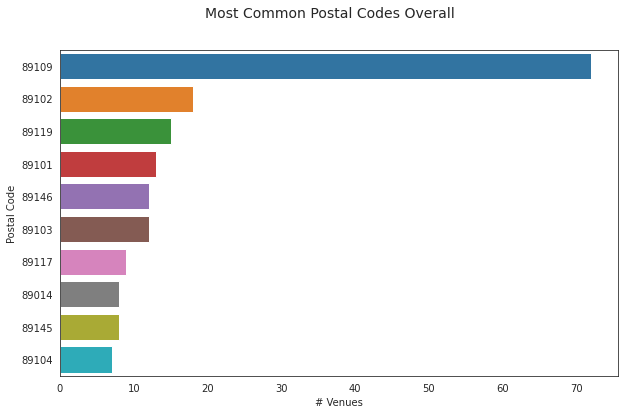

In [ ]:
# Investigating which postal codes have the most venues  
top_postal_count = analysis_df.groupby('Venue_Postal_Code')['Venue_ID'].count().sort_values(ascending=False)[0:10].reset_index()
top_postal_count.columns = ['Postal Code', '# Venues']
top_postal_count['Postal Code'].cat.remove_unused_categories(inplace=True)
top_postal_count.sort_values(by='# Venues', ascending=False, inplace=True)

# Plot the common venue categories
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='# Venues', y='Postal Code',
            data=top_postal_count,
            order=top_postal_count['Postal Code'].values)
fig.suptitle('Most Common Postal Codes Overall', fontsize=14)
fig.show()

print('The most common postal code overall is',
      top_postal_count['Postal Code'][0] + '.\n')

Best top ranked postal code overall is 89101.



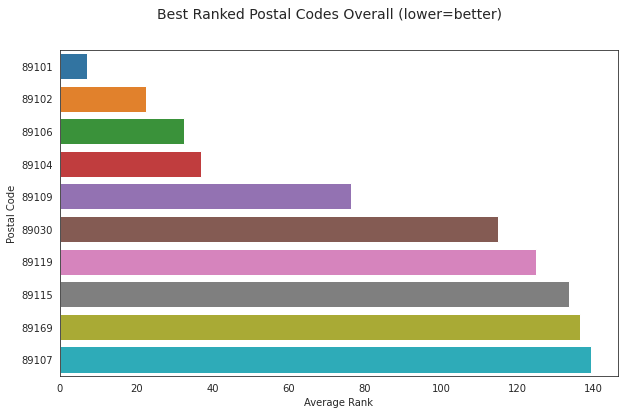

In [ ]:
# Investigating which postal codes have the highest popularity
top_postal_rank = analysis_df.groupby('Venue_Postal_Code')['Venue_Rank'].mean().sort_values(ascending=True)[0:10].reset_index()
top_postal_rank.columns = ['Postal Code', 'Average Rank']
top_postal_rank['Postal Code'].cat.remove_unused_categories(inplace=True)
top_postal_rank.sort_values(by='Average Rank', ascending=True, inplace=True)

# Plotting the results
# Plot the common venue categories
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Average Rank', y='Postal Code',
            data=top_postal_rank,
            order=top_postal_rank['Postal Code'].values)
fig.suptitle('Best Ranked Postal Codes Overall (lower=better)', fontsize=14)
fig.show()

print('Best top ranked postal code overall is',
      top_postal_rank['Postal Code'][0] + '.\n')

Next, we will explore the same for the various venue categories.

The most common venue category overall is Breakfast Spot.



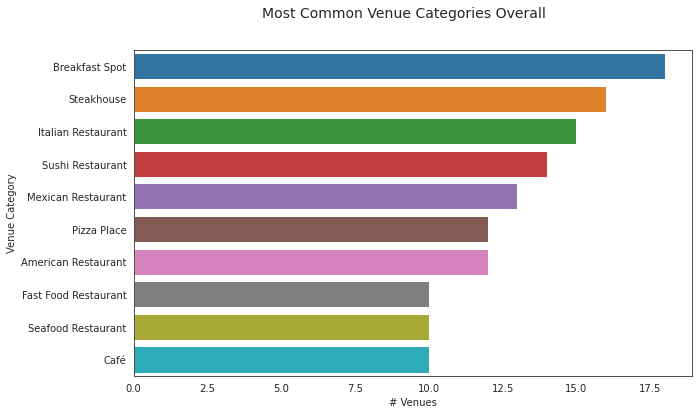

In [ ]:
# Get the 10 most common venue categories
top_cat_count = analysis_df.groupby('Venue_Category')['Venue_ID'].count().sort_values(ascending=False)[0:10].reset_index()
top_cat_count.columns = ['Venue Category', '# Venues']
top_cat_count['Venue Category'].cat.remove_unused_categories(inplace=True)

top_cat_rating = analysis_df.groupby('Venue_Category')['Venue_Rank'].mean().sort_values(ascending=True)[0:10].reset_index()
top_cat_rating.columns = ['Venue Category', 'Average Rank']
top_cat_rating['Venue Category'].cat.remove_unused_categories(inplace=True)

top_cat_count.sort_values(by='# Venues', ascending=False, inplace=True)

# Plot the common venue categories
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='# Venues', y='Venue Category',
            data=top_cat_count,
            order=top_cat_count['Venue Category'].values)
fig.suptitle('Most Common Venue Categories Overall', fontsize=14)
fig.show()

print('The most common venue category overall is',
      top_cat_count['Venue Category'][0] + '.\n')

The best ranked venue category overall is Gastropub. 



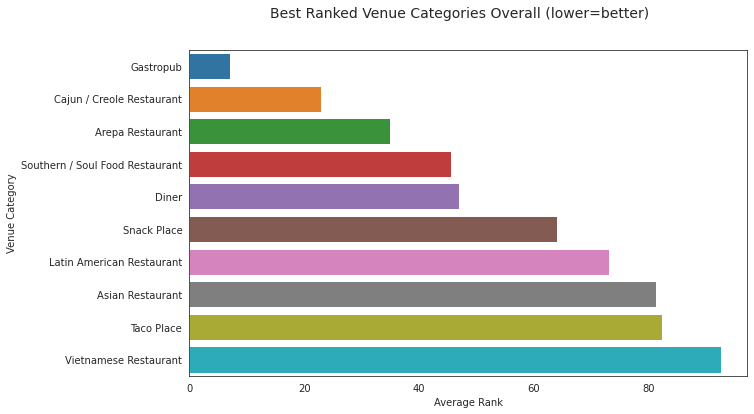

In [ ]:
# Getting the 10 most highly rated venue categories overall
top_cat_rating = analysis_df.groupby('Venue_Category')['Venue_Rank'].mean().sort_values(ascending=True)[0:10].reset_index()
top_cat_rating.columns = ['Venue Category', 'Average Rank']
top_cat_rating['Venue Category'].cat.remove_unused_categories(inplace=True)
top_cat_rating.sort_values(by='Average Rank', inplace=True, ascending=True)

# Plot the top ranked venue categories
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Average Rank', y='Venue Category',
            data=top_cat_rating,
            order=top_cat_rating['Venue Category'].values)
fig.suptitle('Best Ranked Venue Categories Overall (lower=better)', fontsize=14)
fig.show()

print('The best ranked venue category overall is',
      top_cat_rating['Venue Category'][0] + '.', '\n')

Finally, we will explore the distribution of price categories across the selection of venues, as well as how the ranking is in these venues.

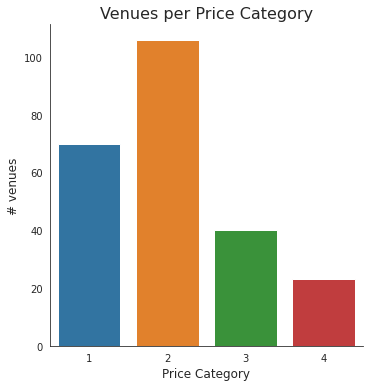

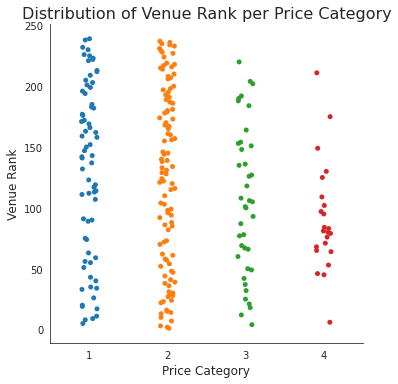

In [ ]:
# Evaluating the distribution of price categories and plotting results

# Creating plot for # Venues per Price Category
sns.catplot(x='Venue_Price_Category', kind='count', 
            data=analysis_df)
plt.title('Venues per Price Category', size=16)
plt.xlabel('Price Category', size=12)
plt.ylabel('# venues', size=12)
plt.show()

# Creating plot for Distribution of venue rankings per price category
sns.catplot(x='Venue_Price_Category', y='Venue_Rank', data=analysis_df)
plt.title('Distribution of Venue Rank per Price Category', size=16)
plt.xlabel('Price Category', size=12)
plt.ylabel('Venue Rank', size=12)
plt.show()

Given the above, we can see there are most venues in price category 2 (the second lowest price category). As for distribution of rankings, there is limited correlation between the categories and ratings for the venues with highest ratings (between 0 and 50), except for it being represented by price categories 1, 2, and 3 - not 4.

###Metric for determining business opportunities
In order to provide recommendations for business opportunities, we will create a metric that answers the following:
1. Which areas are most attractive for new businesses?
2. Which venue categories are recommended in each area?
3. In the most attractive area, what are the recommended venue categories and associated price ranges of the given venue?

We will calculate this as follows:
- Select the 50 most popular venues
- Recommend the most attractive areas according on the mean venue rating for each area
- Recommend venue category based on which venue category is most popular in that area
- Drill down into the most popular postal area, and recommend business opportunities in that area based upon the existing popular venues

Given the above, one will have a good understanding both on the various popular areas, as well as more specifics on the most popular area in Las Vegas.


In [ ]:
# Fetch top 50 venues
top50 = analysis_df.iloc[0:50]
top50['Venue_Postal_Code'].cat.remove_unused_categories(inplace=True)

# Group according to posta codel
top50_df = top50.groupby('Venue_Postal_Code').agg({'Venue_Rank': 'mean', 'Venue_ID' : 'count'}).reset_index().sort_values(by='Venue_Rank')
top50_df.columns = ['Postal Code', 'Average Rank', '# Venues']
top50_df

,Postal Code,Average Rank,# Venues
0,89101,7.0,13
1,89102,22.5,18
3,89106,32.5,2
2,89104,37.0,7
4,89109,45.5,10


In [ ]:
# Calculate the most popular venue categories per postal code

# Count the number of categories
top_cat = top50.groupby(['Postal_Code','Venue_Category']).agg({'Venue_Category': 'count'})
top_cat.columns = ['Category Count']
top_cat.reset_index()

# Sort according to most popular categories, then drop the rest
top_cat = top_cat.sort_values(by=['Postal_Code', 'Category Count'], ascending=False).reset_index()
top_cat.columns = ['Postal Code', 'Venue Category', 'Category Count']
top_cat.drop_duplicates(subset=['Postal Code'], keep='first', inplace=True)

In [ ]:
top50_summary = pd.merge(top50_df, top_cat, on=['Postal Code'])
top50_summary['Venue Category'].cat.remove_unused_categories(inplace=True)
top50_summary

,Postal Code,Average Rank,# Venues,Venue Category,Category Count
0,89101,7.0,13,Pizza Place,3
1,89102,22.5,18,Breakfast Spot,3
2,89106,32.5,2,American Restaurant,1
3,89104,37.0,7,Thai Restaurant,2
4,89109,45.5,10,American Restaurant,2


The above is useful: We now know which are the most popular areas, and which venue types in those areas have the highest prevalence.  
If one is looking to open a food venue in Las Vegas, one should seriously consider the above postal areas and venue categories.

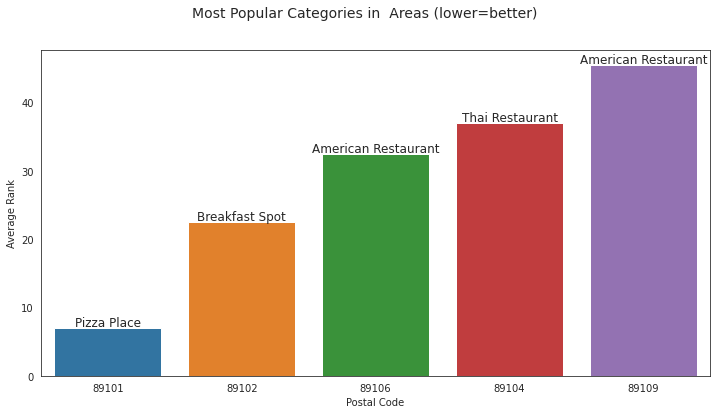

In [ ]:
# Plot the above in a graph
# Plot the top ranked venue categories
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='Postal Code', y='Average Rank',
                  data=top50_summary,
                  order=top50_summary['Postal Code'].values)

# Annotating graph with values
for p in ax.patches:
    ax.annotate(top50_summary.loc[top50_summary['Average Rank']==p.get_height()]['Venue Category'].values[0],
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'top', 
                xytext = (0, 12),
                rotation = 0,
                textcoords = 'offset points',
                size=12
                )

fig.suptitle('Most Popular Categories in  Areas (lower=better)', fontsize=14)
fig.show()

Finally, let us drill down to the most attractive area in this analysis; Postal Code 89101 - which strongly represents the most popular venues.

In [ ]:
top_area = analysis_df.loc[analysis_df['Postal_Code']==top50_summary.iloc[0,0]]
top_area.head(5)

,Venue_Rank,Venue_ID,Venue_Name,Venue_Postal_Code,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Price_Category,Postal_Code,Place_Name,State_Name,State_Code,Country_Code,PC_Latitude,PC_Longitude
0,1,5a32fb62c530935f37812611,Eureka!,89101,36.168976,-115.139580,American Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
1,2,51cde2b08bbd23404bdc1798,Pizza Rock,89101,36.171707,-115.142343,Pizza Place,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
2,3,552ae36a498e9b3b1e232a6e,VegeNation,89101,36.167398,-115.139421,Vegetarian / Vegan Restaurant,2,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
3,4,539a4129498e2eba5804ba4a,Carson Kitchen,89101,36.167884,-115.140664,Gastropub,3,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001
4,5,503cec78e4b0f39ae12141db,eat.,89101,36.166927,-115.139055,Breakfast Spot,1,89101,Las Vegas,Nevada,NV,US,36.17193,-115.14001


To summarize our findings in this area, we will determine the features of the venue category as above, but also include the price ranges.

Based on these features, a new venue with similar features might be able to emulate the popularity of the other venues.

In [ ]:
# Change type of Price category to calculate its average
top_area['Venue_Price_Category'] = top_area['Venue_Price_Category'].astype('int32')

# Calculate the features of each venue category
top_summary = top_area.groupby('Venue_Category').agg({'Venue_Category': 'count', 
                                        'Venue_Rank': 'mean', 
                                        'Venue_Price_Category': 'mean'}).dropna()

# Formatting dataframe for presentation
colnames = ['Venues in category', 'Mean Rank', 'Mean price range']
top_summary.columns = colnames
top_summary = top_summary.sort_values(by='Mean Rank', ascending=True).reset_index()
top_summary.columns = ['Venue Category'] + colnames

print('Characteristics of most popular venues in postal area', top50_summary.iloc[0,0] + '.\n')
top_summary

Characteristics of most popular venues in postal area 89101.



,Venue Category,Venues in category,Mean Rank,Mean price range
0,American Restaurant,1,1.0,2.000000
1,Vegetarian / Vegan Restaurant,1,3.0,2.000000
2,Gastropub,2,7.0,2.500000
3,Pizza Place,3,7.0,1.333333
4,Thai Restaurant,1,7.0,2.000000
5,Breakfast Spot,2,9.0,1.500000
6,Sandwich Place,1,9.0,1.000000
7,Steakhouse,2,9.0,3.500000


The above gives us insight into the characteristics of the most popular venue categories in the most popular postal area.  

If one is to establish a new venture in this area, it would likely be beneficial to consider using the venue categories in the above list, while ensuring the price range is within the similar range.

###Machine Learning to assign Venues to Clusters with k-Means

In this section, we will use the k-Means machine learning algorithm to see if we can group the various venues we have in our dataset into clusters based on their similar features.

Since many of the features we are using in the dataset are categorical variables (also called factor variables), we are going to create dummies with these features through one-hot encoding.

Specifically, we are going to do the below steps:
1. Transform the ratings of the venues into 5 groups, with ratings from "Very high" to "Very low"  
2. Include all features into a dataframe, one-hot enocde the data
3. We will create the cluster according to the postal codes, since these appear to be highly relevant in determining the rank of a given venue
4. Evaluate the clusters for the high-rated venues, and investigate which features seem to be linked to high (and low) ratings

In [ ]:
# Grouping the venue ratings into categories
pop_groups = 5 # making 5 groups
pop_labels = ['Very high', 'High', 'Medium', 'Low', 'Very low']
cluster_df = analysis_df.copy(deep=True)
cluster_df['Venue_Popularity'] = pd.cut(cluster_df['Venue_Rank'],
                                             bins = pop_groups,
                                             labels = pop_labels,
                                             precision = 0,
                                             ordered = False)
cluster_df['Venue_Popularity'].value_counts()

Very low     48
Low          48
High         48
Very high    48
Medium       47
Name: Venue_Popularity, dtype: int64

#### Converting features using one-hot encoding
Having done the above, we will apply one-hot enconding using dummies.

In [ ]:
# Converting Venue Popularity to one hot encoding using dummies
pop_onehot = pd.get_dummies(cluster_df[['Venue_Popularity']], prefix='', prefix_sep='')
pop_onehot = pd.concat([cluster_df['Venue_Postal_Code'], pop_onehot], axis=1)

# Grouping the postal codes according to the mean number of each popularity category
pop_grouped = pop_onehot.groupby('Venue_Postal_Code').mean().reset_index()

# Renaming the columns for legibility:
colnames = pop_grouped.columns.values
colnames = np.append(colnames[0], 'Popularity ' + np.array(colnames[1:]))
pop_grouped.columns = colnames

pop_grouped.head(3)

,Venue_Postal_Code,Popularity Very high,Popularity High,Popularity Medium,Popularity Low,Popularity Very low
0,89014,0.0,0.0,0.0,0.0,1.0
1,89030,0.0,0.0,1.0,0.0,0.0
2,89031,0.0,0.0,0.0,0.0,1.0


Next, we will also convert the venues' price categories to dummies using the same procedure as above.

In [ ]:
# Convert Venue Price Category to one hot encoding using dummies
pricecat_onehot = pd.get_dummies(cluster_df[['Venue_Price_Category']], prefix='', prefix_sep='')

# add the postal code into the one hot dataframe
pricecat_onehot = pd.concat([cluster_df['Venue_Postal_Code'], pricecat_onehot], axis=1)

# grouping the postal areas according to the mean number of each price category
pricecat_grouped = pricecat_onehot.groupby('Venue_Postal_Code').mean().reset_index()

# Renaming price category dummy names for legibility
colnames = pricecat_grouped.columns.values
colnames = np.append(colnames[0], 'Price Category ' + np.array(colnames[1:]))
pricecat_grouped.columns = colnames

pricecat_grouped.head(3)

,Venue_Postal_Code,Price Category 1,Price Category 2,Price Category 3,Price Category 4
0,89014,0.5,0.375,0.125,0.0
1,89030,0.6,0.400,0.000,0.0
2,89031,0.0,1.000,0.000,0.0


As the final step of the one-hot encoding, we will do this for each venue category as well.

In [ ]:
# Convert Venue Category to one hot encoding using dummies
ven_cat_onehot = pd.get_dummies(cluster_df[['Venue_Category']], prefix='', prefix_sep='')

# add the postal code into the one hot dataframe
ven_cat_onehot = pd.concat([cluster_df['Venue_Postal_Code'], ven_cat_onehot], axis=1)

# grouping the postal areas according to the mean number of each category
ven_cat_grouped = ven_cat_onehot.groupby('Venue_Postal_Code').mean().reset_index()

# Renaming category dummy names for readability
colnames = ven_cat_grouped.columns.values
colnames = np.append(colnames[0], 'Category: ' + np.array(colnames[1:]))
ven_cat_grouped.columns = colnames

ven_cat_grouped.head(3)

,Venue_Postal_Code,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
0,89014,0.0,0.125,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,89030,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.200,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.6,0.0,0.0,0.0,0.2,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,89031,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Having converted the features above using one-hot encoding, we will merge them together into one dataframe which combines all the dummies (features).

In [ ]:
# Joining the dummies dataframes together
areas_grouped = pd.merge(pop_grouped, pricecat_grouped, on='Venue_Postal_Code')
areas_grouped = pd.merge(areas_grouped, ven_cat_grouped, on='Venue_Postal_Code')
areas_grouped.head(10)

,Venue_Postal_Code,Popularity Very high,Popularity High,Popularity Medium,Popularity Low,Popularity Very low,Price Category 1,Price Category 2,Price Category 3,Price Category 4,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
0,89014,0.0,0.0,0.0,0.0,1.0,0.500000,0.375000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.0,0.125,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.125,0.0,0.0,0.000000,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.125,0.0,0.000000,0.000000,0.000000,0.125000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125,0.125000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00
1,89030,0.0,0.0,1.0,0.0,0.0,0.600000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.200000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.600000,0.0,0.000000,0.000000,0.200000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00
2,89031,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.00
3,89032,0.0,0.0,0.0,1.0,0.0,0.250000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.25
4,89084,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.500000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00
5,89101,1.0,0.0,0.0,0.0,0.0,0.307692,0.461538,0.153846,0.076923,0.076923,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.153846,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.153846,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.230769,0.000,0.076923,0.000000,0.0,0.0,0.0,0.153846,0.000000,0.000000,0.0,0.076923,0.

####Clustering venues 
Now we have the data we need to carry out the k-Means clustering. We are going to perform this using 5 clusters.

In [ ]:
# defining number of clusters
klusters = 5

# keep only the relevant features; i.e. dropping the postal code
areas_cluster = areas_grouped.drop('Venue_Postal_Code', 1)

# run K-means clustering
kmeans = KMeans(n_clusters=klusters, random_state=0).fit(areas_cluster)

# list the labels; i.e. the cluster categories generated by the algorithm
kmeans.labels_

array([0, 2, 0, 1, 0, 3, 3, 1, 3, 3, 2, 0, 2, 2, 2, 0, 0, 2, 0, 1, 4, 0,
       4, 0, 1, 4, 1, 1, 0, 1, 2], dtype=int32)

Having performed the clustering, we will merge them into the dataframe with the features. In the below dataframe, these clusters are now listed in the "Cluster" column.

In [ ]:
# add clusters back into dataframe
areas_grouped.insert(1, 'Cluster', kmeans.labels_)
areas_grouped.head(10)

,Venue_Postal_Code,Cluster,Popularity Very high,Popularity High,Popularity Medium,Popularity Low,Popularity Very low,Price Category 1,Price Category 2,Price Category 3,Price Category 4,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
0,89014,0,0.0,0.0,0.0,0.0,1.0,0.500000,0.375000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.0,0.125,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.125,0.0,0.0,0.000000,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.125,0.0,0.000000,0.000000,0.000000,0.125000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125,0.125000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00
1,89030,2,0.0,0.0,1.0,0.0,0.0,0.600000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.200000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.600000,0.0,0.000000,0.000000,0.200000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00
2,89031,0,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.00
3,89032,1,0.0,0.0,0.0,1.0,0.0,0.250000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.25
4,89084,0,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.500000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00
5,89101,3,1.0,0.0,0.0,0.0,0.0,0.307692,0.461538,0.153846,0.076923,0.076923,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.153846,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.153846,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.230769,0.000,0.076923,0.000000,0.0,0.0,0.0,0.153846,0.000000,0.00

To get some more sense out of the characteristics of each individual cluster, let's sort the dataframe to investigate whether the patterns seem to make sense.

In [ ]:
areas_grouped.sort_values(by='Cluster')

,Venue_Postal_Code,Cluster,Popularity Very high,Popularity High,Popularity Medium,Popularity Low,Popularity Very low,Price Category 1,Price Category 2,Price Category 3,Price Category 4,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
0,89014,0,0.000000,0.000000,0.000000,0.000,1.000,0.500000,0.375000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28,89147,0,0.000000,0.000000,0.000000,0.000,1.000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,89129,0,0.000000,0.000000,0.000000,0.000,1.000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,89123,0,0.000000,0.000000,0.000000,0.000,1.000,0.333333,0.666667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18,89120,0,0.000000,0.000000,0.000000,0.000,1.000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00000

The above clusters seem to make a good job of categorizing the various venue types. In order to make this more clear, we will group them together and calculate the mean of each feature.

In [ ]:
# Grouping on the given clusters to view their relevant details
mean_clusters = areas_grouped.groupby('Cluster').mean().reset_index()
mean_clusters['Cluster'] = mean_clusters['Cluster'].astype('category')
mean_clusters

,Cluster,Popularity Very high,Popularity High,Popularity Medium,Popularity Low,Popularity Very low,Price Category 1,Price Category 2,Price Category 3,Price Category 4,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
0,0,0.000000,0.000000,0.000000,0.000000,1.000000,0.283333,0.693056,0.012500,0.011111,0.000000,0.029167,0.000000,0.000000,0.000000,0.000000,0.012500,0.000000,0.200000,0.000000,0.033333,0.038889,0.000000,0.000000,0.045833,0.000000,0.000000,0.000000,0.050000,0.000000,0.029167,0.000000,0.016667,0.016667,0.0125,0.000000,0.000000,0.011111,0.033333,0.012500,0.000000,0.027778,0.033333,0.000000,0.000000,0.072222,0.0125,0.023611,0.000000,0.000000,0.000000,0.000000,0.027778,0.111111,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.982143,0.017857,0.325000,0.452381,0.182143,0.040476,0.065476,0.011905,0.000000,0.035714,0.035714,0.017857,0.000000,0.000000,0.047619,0.000000,0.023810,0.070238,0.000000,0.000000,0.000000,0.000000,0.028571,0.011905,0.035714,0.000000,0.011905,0.000000,0.000000,0.000000,0.0000,0.000000,0.011905,0.077381,0.023810,0.011905,0.000000,0.111905,0.000000,0.000000,0.035714,0.035714,0.0000,0.000000,0.069048,0.000000,0.000000,0.000000,0.053571,0.083333,0.000000,0.011905,0.011905,0.000000,0.017857,0.011905,0.035714
2,2,0.015873,0.095238,0.888889,0.000000,0.000000,0.320635,0.494841,0.131746,0.052778,0.017460,0.000000,0.000000,0.003968,0.005952,0.000000,0.037698,0.045238,0.005952,0.001984,0.015476,0.075397,0.000000,0.009524,0.000000,0.001984,0.000000,0.000000,0.140079,0.015873,0.030556,0.000000,0.000000,0.000000,0.0000,0.009524,0.000000,0.032937,0.013492,0.035714,0.001984,0.139286,0.000000,0.013492,0.000000,0.034524,0.0000,0.073413,0.088889,0.003968,0.001984,0.001984,0.061111,0.015476,0.051587,0.000000,0.000000,0.001984,0.009524,0.000000,0.001984
3,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.364621,0.375305,0.240842,0.019231,0.179945,0.000000,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.080128,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.063492,0.000000,0.000000,0.038462,0.000000,0.000000,0.0000,0.000000,0.000000,0.013889,0.013889,0.013889,0.000000,0.000000,0.000000,0.013889,0.000000,0.071581,0.0000,0.033120,0.013889,0.000000,0.125000,0.000000,0.038462,0.041667,0.035714,0.000000,0.104548,0.000000,0.019231,0.013889,0.000000
4,4,0.000000,0.000000,0.000000,0.000000,1.000000,0.833333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000

In [ ]:
# Creating subset of Price category features

# Converting category columns to rows
pcat_df = mean_clusters.iloc[:,6:10].stack().reset_index()

# Renaming columns
pcat_df.columns = ['Cluster', 'Price Category', 'Mean value']

# Removing uncessary label text
pcat_df['Price Category'] = pcat_df['Price Category'].str.replace('Price Category ','')
pcat_df.head(10)

,Cluster,Price Category,Mean value
0,0,1,0.283333
1,0,2,0.693056
2,0,3,0.012500
3,0,4,0.011111
4,1,1,0.325000
5,1,2,0.452381
6,1,3,0.182143
7,1,4,0.040476
8,2,1,0.320635
9,2,2,0.494841


Let's break down the popularity per cluster visually.

In [ ]:
# Creating subset of Popularity features

# Converting popularity columns to rows
pop_df = mean_clusters.iloc[:,1:6].stack().reset_index()

# Renaming columns
pop_df.columns = ['Cluster', 'Popularity',  'Mean value']

# Removing uncessary label text
pop_df['Popularity'] = pop_df['Popularity'].str.replace('Popularity ','')
pop_df.head(10)

,Cluster,Popularity,Mean value
0,0,Very high,0.000000
1,0,High,0.000000
2,0,Medium,0.000000
3,0,Low,0.000000
4,0,Very low,1.000000
5,1,Very high,0.000000
6,1,High,0.000000
7,1,Medium,0.000000
8,1,Low,0.982143
9,1,Very low,0.017857


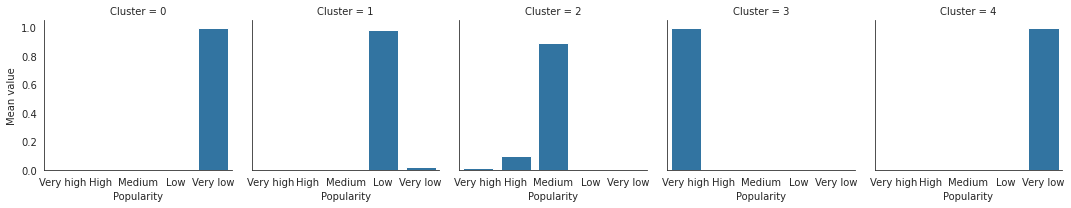

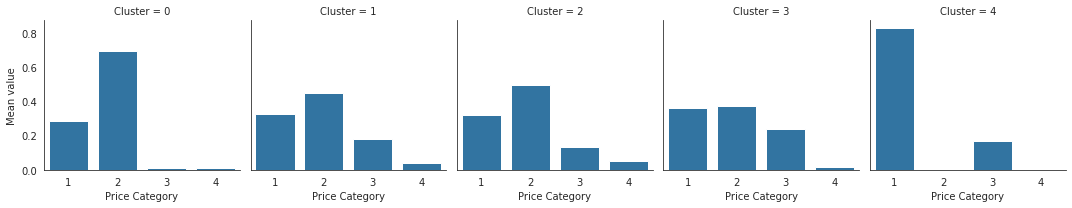

In [ ]:
# Create facet grids of results
g1 = sns.FacetGrid(pop_df, col='Cluster')
g1.map(sns.barplot, 'Popularity', 'Mean value')
plt.show()

g2 = sns.FacetGrid(pcat_df, col='Cluster')
g2.map(sns.barplot, 'Price Category', 'Mean value')

plt.show()

The above gives us very useful feedback. We can see the following:
- Which clusters have the highest average popularity
- Which clusters have the lowest average popularity
- How the price categories are distributed according to the clusters

Since these clusters perform an average of all the postal codes, there will be individual variations across the various postal areas.

If one is going to establish a new business in one of the individual postal codes, it makes sense to look at what the features are per postal area. We do this below by subsetting on the most popular clusters.

Finally we will do the following:
1. Create a dataframe with the two clusters with highest popularity
2. Show each postal code associated with the cluster
3. Break down the three most popular venue categories in the cluster
4. Break down the two most popular price categories in the cluster

In [ ]:
# Subsetting data frame into the poplar clusters and recommended clusters
pop_subset = areas_grouped.loc[(areas_grouped['Cluster'] == 2) | (areas_grouped['Cluster'] == 3)].sort_values(by=['Cluster'])
rec_subset = areas_grouped.loc[areas_grouped['Cluster']==3].sort_values(by=['Venue_Postal_Code'])

# Investigating the subset of all the popular venues
pop_subset.head(5)

,Venue_Postal_Code,Cluster,Popularity Very high,Popularity High,Popularity Medium,Popularity Low,Popularity Very low,Price Category 1,Price Category 2,Price Category 3,Price Category 4,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
1,89030,2,0.000000,0.000000,1.000000,0.0,0.0,0.600000,0.400000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.600000,0.0,0.000000,0.0,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
10,89107,2,0.000000,0.000000,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
12,89109,2,0.111111,0.666667,0.222222,0.0,0.0,0.194444,0.347222,0.222222,0.236111,0.055556,0.0,0.0,0.027778,0.041667,0.0,0.013889,0.0,0.041667,0.013889,0.041667,0.027778,0.0,0.0,0.0,0.013889,0.0,0.0,0.013889,0.111111,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.097222,0.027778,0.0,0.013889,0.041667,0.0,0.027778,0.0,0.041667,0.0,0.013889,0.055556,0.027778,0.013889,0.013889,0.111111,0.041667,0.027778,0.0,0.0,0.013889,0.0,0.0,0.013889
13,89110,2,0.000000,0.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000
14,89115,2,0.000000,0.000000,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [ ]:
# Subset on Postal Code and Category
pop_df = pop_subset[pop_subset.columns[11:]].copy(deep=True)
pop_df.insert(0,'Postal Code', pop_subset['Venue_Postal_Code'])
pop_df.head(5)

,Postal Code,Category: American Restaurant,Category: Andhra Restaurant,Category: Arepa Restaurant,Category: Asian Restaurant,Category: BBQ Joint,Category: Bagel Shop,Category: Bakery,Category: Brazilian Restaurant,Category: Breakfast Spot,Category: Buffet,Category: Burger Joint,Category: Café,Category: Cajun / Creole Restaurant,Category: Caribbean Restaurant,Category: Deli / Bodega,Category: Diner,Category: Dumpling Restaurant,Category: Eastern European Restaurant,Category: Fast Food Restaurant,Category: French Restaurant,Category: Fried Chicken Joint,Category: Gastropub,Category: German Restaurant,Category: Greek Restaurant,Category: Hawaiian Restaurant,Category: Indian Restaurant,Category: Irish Pub,Category: Italian Restaurant,Category: Japanese Restaurant,Category: Korean Restaurant,Category: Latin American Restaurant,Category: Mexican Restaurant,Category: Middle Eastern Restaurant,Category: New American Restaurant,Category: Noodle House,Category: Pizza Place,Category: Restaurant,Category: Sandwich Place,Category: Seafood Restaurant,Category: Snack Place,Category: Southern / Soul Food Restaurant,Category: Spanish Restaurant,Category: Steakhouse,Category: Sushi Restaurant,Category: Taco Place,Category: Tapas Restaurant,Category: Thai Restaurant,Category: Theme Restaurant,Category: Vegetarian / Vegan Restaurant,Category: Vietnamese Restaurant,Category: Wings Joint
1,89030,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.600000,0.0,0.000000,0.0,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
10,89107,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
12,89109,0.055556,0.0,0.0,0.027778,0.041667,0.0,0.013889,0.0,0.041667,0.013889,0.041667,0.027778,0.0,0.0,0.0,0.013889,0.0,0.0,0.013889,0.111111,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.097222,0.027778,0.0,0.013889,0.041667,0.0,0.027778,0.0,0.041667,0.0,0.013889,0.055556,0.027778,0.013889,0.013889,0.111111,0.041667,0.027778,0.0,0.0,0.013889,0.0,0.0,0.013889
13,89110,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000
14,89115,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


Now we will make a function that takes a row as input and returns that row with the x-most popular venue categories.

In [ ]:
def stack_most_common_venues(row, no_top_venues):
  """Function to retrieve and stack the most common venue categories"""
  top_venues_stacked = row.iloc[1:].sort_values(ascending=False).reset_index().iloc[0:no_top_venues,:]
  top_venues_stacked.insert(0,'Postal Code',row.iloc[0])
  top_venues_stacked.columns.values[1:] = ['Venue Category', 'Category Prevalence %']
  top_venues_stacked['Rank in Postal Area'] = np.arange(1,no_top_venues+1)
  top_venues_stacked['Venue Category'] = top_venues_stacked['Venue Category'].str.replace('Category: ','')
  # converting to percentage
  top_venues_stacked['Category Prevalence %'] = top_venues_stacked['Category Prevalence %'] * 100
  
  return top_venues_stacked

Having defined the above, we will make calls to it and create a new dataframe that lists the most popular postal code areas, along with the most popular venue categories, as well as their rank and prevalence within that area.

In [ ]:
# Creating a dataframe to Details of the 3 most common venue categories per postal code
no_top_venues = 3

col_names = ['Postal Code', 'Venue Category', 'Category Prevalence %', 'Rank in Postal Area']
pop_venues = pd.DataFrame(columns=col_names)
for ind in np.arange(pop_df.shape[0]):
  pop_venues = pd.concat([pop_venues, stack_most_common_venues(pop_df.iloc[ind,:],no_top_venues)])

# resetting the index
pop_venues.reset_index(drop=True, inplace=True)

# dropping rows with 0% prevalence
pop_venues.drop(pop_venues.loc[pop_venues['Category Prevalence %'] == 0].index, 
                        inplace=True)

pop_venues.head(5)

,Postal Code,Venue Category,Category Prevalence %,Rank in Postal Area
0,89030,Mexican Restaurant,60,1
1,89030,Fried Chicken Joint,20,2
2,89030,Pizza Place,20,3
3,89107,Sandwich Place,50,1
4,89107,Seafood Restaurant,50,2


In order to represent the above visually, we will create a function that will make a facet grid for us with the relenvant details.

In [ ]:
def plot_venues(venue_df, cols, title):
  """Fuction to plot the most hot venues per postal code"""
  sns.set_theme(style="ticks")
  no_graphs = len(venue_df['Postal Code'].unique())
  rows = math.ceil(no_graphs/cols)

  # Initialize the graph
  fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20,4*rows))
  fig.suptitle(title, fontsize=15)
  fig.subplots_adjust(hspace=0.7, wspace=0.3)

  # Create a for loop to create a separate graph per postal area
  for count, pc in enumerate(venue_df['Postal Code'].unique(),1):
    # calculate the row- and column axis
    row = math.ceil(count/cols)-1
    col = (count-1) - row*cols
    # Add plot
    g = sns.barplot(data=venue_df.loc[venue_df['Postal Code']==pc], 
                x='Venue Category',
                y='Category Prevalence %', ax = ax[row,col])
    g.set_xticklabels(g.get_xticklabels(), rotation=20)
    g.set_xlabel('')
    ax[row,col].set_title('Postal Code '+ pc)
  #fig.tight_layout()
  fig.show() 

Having defined the above function, we will first make graphs of all the popular areas to investigate their characteristics. In the step afterwards, we will do the same but only for the venues we are going to recommend for this analysis.

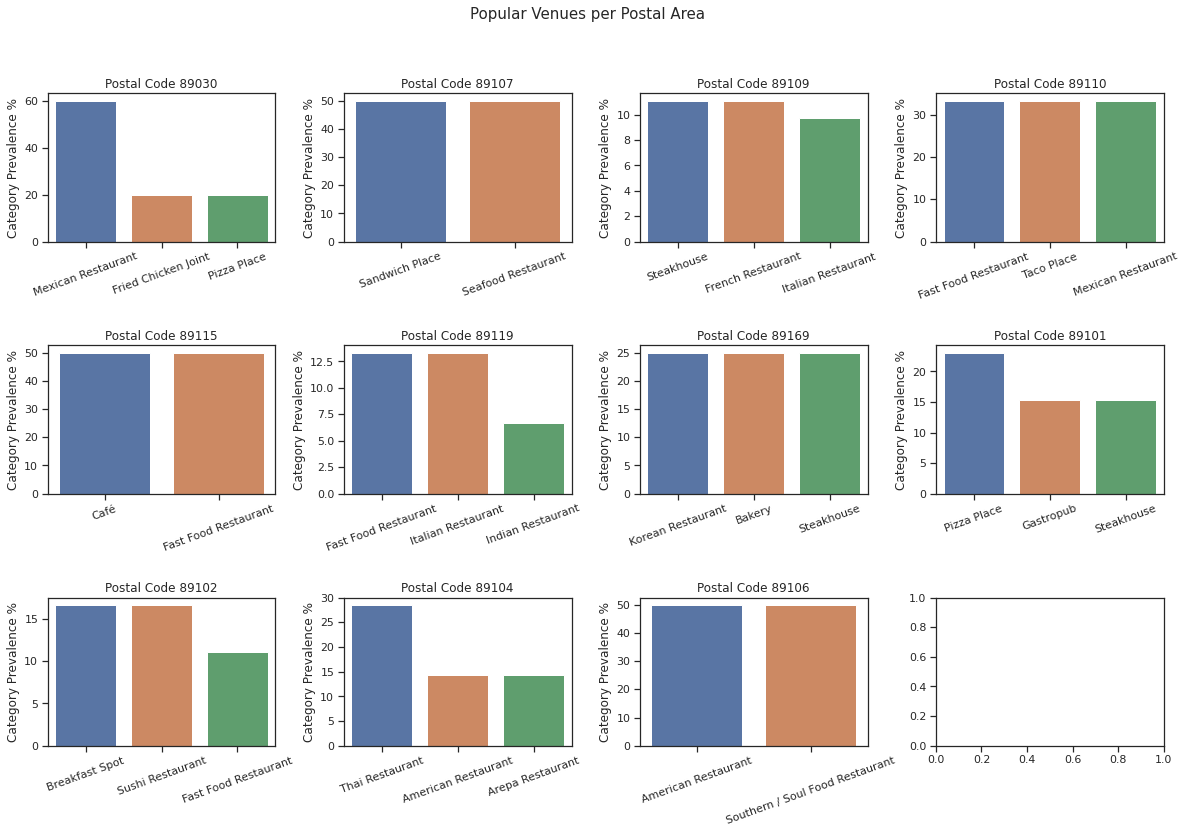

In [ ]:
plot_venues(pop_venues, 4, 'Popular Venues per Postal Area')

In [ ]:
# Now let's only look at the recommended venues (most popular)

# First subset the popular venues from the most popular cluster
rec_venues = pop_venues.loc[pop_venues['Postal Code'].isin(rec_subset['Venue_Postal_Code'])]

# list venues
rec_venues

,Postal Code,Venue Category,Category Prevalence %,Rank in Postal Area
21,89101,Pizza Place,23.0769,1
22,89101,Gastropub,15.3846,2
23,89101,Steakhouse,15.3846,3
24,89102,Breakfast Spot,16.6667,1
25,89102,Sushi Restaurant,16.6667,2
26,89102,Fast Food Restaurant,11.1111,3
27,89104,Thai Restaurant,28.5714,1
28,89104,American Restaurant,14.2857,2
29,89104,Arepa Restaurant,14.2857,3
30,89106,American Restaurant,50,1


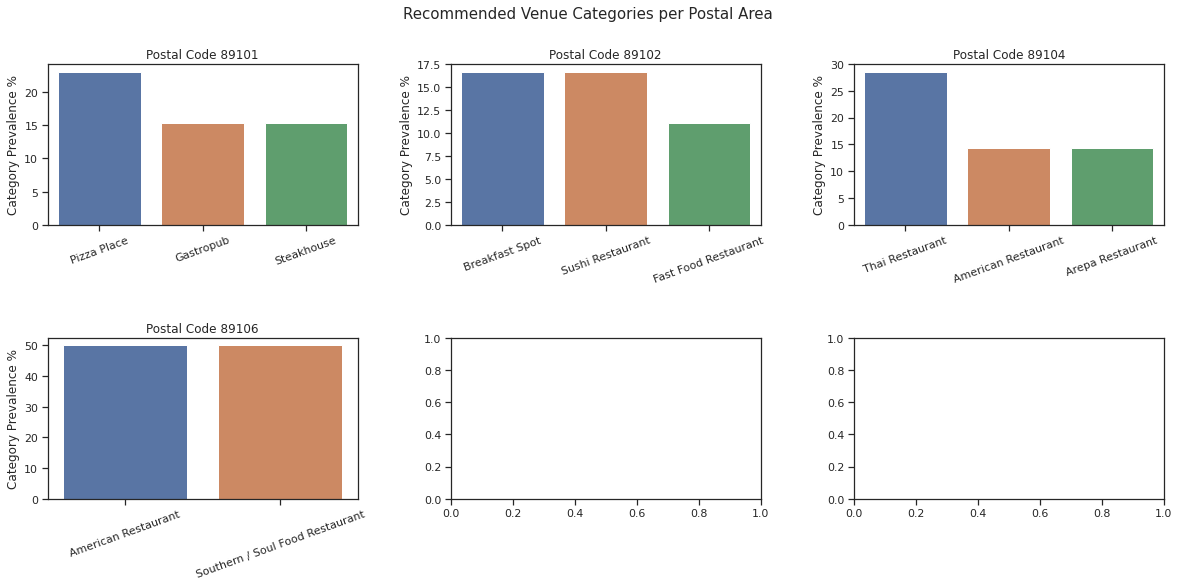

In [ ]:
# Now let's plot the top recommended venues
plot_venues(rec_venues, 
                     3, 'Recommended Venue Categories per Postal Area')

##4. Conclusion <a name="conclusion"></a>

Given the above data collection, pre-processing, and analysis, we now have a good basis for identifying what might be good business opportunities for food in the Las Vegas area.